# Project 4 — Module 5: Statistical Inference
## Lesson 5: Confidence Intervals

| | |
|---|---|
| **Author** | Jose Marcel Lopez Pino |
| **Framework** | CRISP-DM + LEAN |
| **Phase** | 5 — Evaluation |
| **Module** | 5 — Statistical Inference (Alkemy Bootcamp) |
| **Dataset** | Student Habits vs Academic Performance — Kaggle |
| **Date** | 2026-02 |

---

> **Executive Summary:**
> This notebook corresponds to Lesson 5 of Module 5 (Statistical Inference).
> Confidence intervals (90%, 95%, 99%) are calculated for key variables
> (sleep_hours, exam_score, exercise_frequency). The impact of sample size
> on interval width is analyzed. Results are interpreted in business terms
> and directly inform the hypothesis testing decisions in Lesson 6.

---

## Table of Contents

1. [CRISP-DM Phase 5 — Evaluation](#1-crisp-dm-phase-5--evaluation)
2. [Load Data](#2-load-data)
3. [CI Framework — Theoretical Background](#3-ci-framework--theoretical-background)
4. [CI for sleep_hours — H1 Context](#4-ci-for-sleep_hours--h1-context)
5. [CI for exam_score — Baseline](#5-ci-for-exam_score--baseline)
6. [CI for exercise_frequency — H2, H3 Context](#6-ci-for-exercise_frequency--h2-h3-context)
7. [Confidence Level Comparison — 90% vs 95% vs 99%](#7-confidence-level-comparison--90-vs-95-vs-99)
8. [Sample Size Impact on CI Width](#8-sample-size-impact-on-ci-width)
9. [Business Objectives Review](#9-business-objectives-review)
10. [LEAN Filter — Waste Elimination Review](#10-lean-filter--waste-elimination-review)
11. [Decisions Log — Lesson 5](#11-decisions-log--lesson-5)

---
## 1. CRISP-DM Phase 5 — Evaluation

**Objective:** Estimate population parameters using confidence intervals.
Evaluate whether the intervals include or exclude the benchmark values
defined in the hypotheses (H1: μ=7, H3: p=0.50).

**Lean Filter:** Calculate CIs only for variables directly linked to
the research questions. A CI that doesn't inform a business decision is waste.

> **Key question for this phase:**
> *Do the confidence intervals for sleep_hours and exam_score
> include or exclude the benchmark values from our hypotheses?*

### Success Criteria Review (from Lesson 1)

| Criterion | Target | Status |
|-----------|--------|--------|
| Statistical validity | p-value < 0.05 where applicable | ⏳ Lesson 6 |
| Business relevance | At least 2 concrete recommendations | ⏳ Lesson 6 |
| Reproducibility | All code runs end-to-end | ✅ random_state=42 |
| Portfolio quality | Dual-format delivery | ⏳ Lesson 6 |

In [1]:
# ===== Environment Setup =====
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import t, norm

np.random.seed(42)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Blues_d')

DATA_RAW        = Path('../data/raw')
REPORTS_FIGURES = Path('../reports/figures')
REPORTS_FIGURES.mkdir(parents=True, exist_ok=True)

print('Environment ready.')

Environment ready.


---
## 2. Load Data

In [2]:
# ===== Load Dataset =====
CSV_FILE = DATA_RAW / 'student_habits_performance.csv'
df = pd.read_csv(CSV_FILE)

sleep    = df['sleep_hours'].dropna()
score    = df['exam_score'].dropna()
exercise = df['exercise_frequency'].dropna()

print(f'Dataset loaded: {df.shape[0]:,} rows x {df.shape[1]} columns')

Dataset loaded: 1,000 rows x 16 columns


---
## 3. CI Framework — Theoretical Background

### Confidence Interval Formula (t-distribution)

$$CI = \bar{X} \pm t_{\alpha/2, n-1} \cdot \frac{s}{\sqrt{n}}$$

| Component | Symbol | Meaning |
|-----------|--------|---------|
| Sample mean | X̄ | Point estimate |
| t critical value | t_{α/2, n-1} | Depends on confidence level and df |
| Standard error | s/√n | Precision of the estimate |

### Confidence Level → Alpha → Critical Value

| Confidence Level | α | α/2 | t critical (n=1000) |
|-----------------|---|-----|---------------------|
| 90% | 0.10 | 0.05 | ≈ 1.646 |
| 95% | 0.05 | 0.025 | ≈ 1.962 |
| 99% | 0.01 | 0.005 | ≈ 2.581 |

### Interpretation Rule

> A 95% CI means: if we repeated this sampling procedure 100 times,
> approximately 95 of the resulting intervals would contain the true population mean.
> **It does NOT mean there is a 95% probability the true mean is in this specific interval.**

In [3]:
# ===== CI Helper Function =====
def confidence_interval(data: pd.Series, confidence: float = 0.95) -> dict:
    """Calculates confidence interval for the mean using t-distribution.

    Args:
        data: Sample data as Series.
        confidence: Confidence level (default 0.95).

    Returns:
        dict with n, mean, std, se, t_critical, ci_lower, ci_upper, width.
    """
    n    = len(data)
    mean = data.mean()
    std  = data.std(ddof=1)
    se   = std / np.sqrt(n)
    alpha = 1 - confidence
    t_crit = t.ppf(1 - alpha/2, df=n-1)
    margin = t_crit * se

    return {
        'n':          n,
        'mean':       round(mean, 4),
        'std':        round(std, 4),
        'se':         round(se, 4),
        't_critical': round(t_crit, 4),
        'margin':     round(margin, 4),
        'ci_lower':   round(mean - margin, 4),
        'ci_upper':   round(mean + margin, 4),
        'width':      round(2 * margin, 4)
    }


print('CI function ready.')

CI function ready.


---
## 4. CI for sleep_hours — H1 Context

**Hypothesis H1:** H₀: μ_sleep = 7 | H₁: μ_sleep < 7

**Business question:** Does the CI for mean sleep duration exclude 7h (the WHO benchmark)?
If the entire CI is below 7, this provides strong preliminary evidence for H1.

In [4]:
# ===== CI for sleep_hours =====
benchmark_sleep = 7.0

for conf in [0.90, 0.95, 0.99]:
    ci = confidence_interval(sleep, confidence=conf)
    excludes = '✅ Excludes benchmark' if ci['ci_upper'] < benchmark_sleep else '⚠️  Includes benchmark'
    print(f'{int(conf*100)}% CI: [{ci["ci_lower"]:.4f}, {ci["ci_upper"]:.4f}]  '
          f'width={ci["width"]:.4f}  {excludes}')

print()
ci_95 = confidence_interval(sleep, confidence=0.95)
print('=== 95% CI Details ===')
for k, v in ci_95.items():
    print(f'  {k:<15} = {v}')

90% CI: [6.4063, 6.5339]  width=0.1277  ✅ Excludes benchmark
95% CI: [6.3940, 6.5462]  width=0.1522  ✅ Excludes benchmark
99% CI: [6.3700, 6.5702]  width=0.2002  ✅ Excludes benchmark

=== 95% CI Details ===
  n               = 1000
  mean            = 6.4701
  std             = 1.2264
  se              = 0.0388
  t_critical      = 1.9623
  margin          = 0.0761
  ci_lower        = 6.394
  ci_upper        = 6.5462
  width           = 0.1522


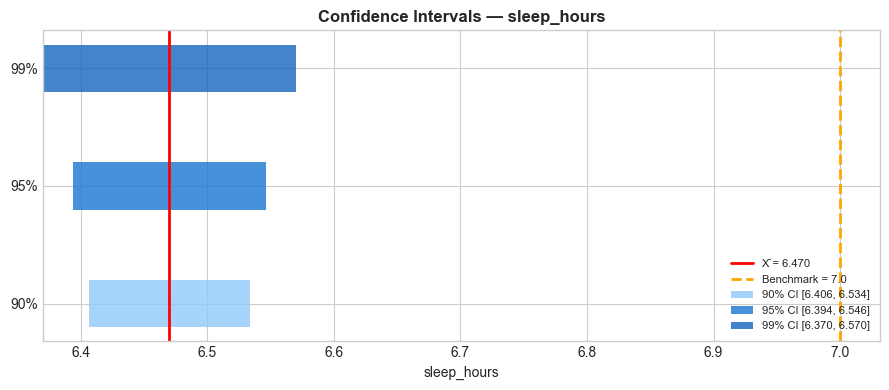

Figure saved: ..\reports\figures\lesson5_ci_sleep.png

=== Business Interpretation ===
→ The 95% CI [6.394, 6.546] lies entirely below 7h
→ Strong preliminary evidence that μ_sleep < 7h — supports H1
→ Formal test in Lesson 6 will confirm with p-value


In [5]:
# ===== Plot — CI for sleep_hours =====
def plot_ci_benchmark(data: pd.Series, var_name: str, benchmark: float,
                      confidences: list, figname: str) -> None:
    """Plots confidence intervals at multiple levels with benchmark reference line.

    Args:
        data: Sample data.
        var_name: Variable name for labels.
        benchmark: Reference value (e.g. WHO 7h).
        confidences: List of confidence levels to plot.
        figname: Output filename.

    Returns:
        None
    """
    fig, ax = plt.subplots(figsize=(9, 4))
    mean = data.mean()

    colors = ['#90CAF9', '#1976D2', '#1565C0']
    for i, conf in enumerate(confidences):
        ci = confidence_interval(data, confidence=conf)
        ax.barh(i, ci['width'], left=ci['ci_lower'],
                height=0.4, color=colors[i], alpha=0.8,
                label=f'{int(conf*100)}% CI [{ci["ci_lower"]:.3f}, {ci["ci_upper"]:.3f}]')

    ax.axvline(mean, color='red', linestyle='-', lw=2, label=f'X̄ = {mean:.3f}')
    ax.axvline(benchmark, color='orange', linestyle='--', lw=2,
               label=f'Benchmark = {benchmark}')
    ax.set_yticks(range(len(confidences)))
    ax.set_yticklabels([f'{int(c*100)}%' for c in confidences])
    ax.set_xlabel(var_name)
    ax.set_title(f'Confidence Intervals — {var_name}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=8, loc='lower right')
    plt.tight_layout()
    output_path = REPORTS_FIGURES / figname
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f'Figure saved: {output_path}')


plot_ci_benchmark(sleep, 'sleep_hours', benchmark_sleep,
                  [0.90, 0.95, 0.99],
                  figname='lesson5_ci_sleep.png')

print()
print('=== Business Interpretation ===')
ci_95 = confidence_interval(sleep, 0.95)
if ci_95['ci_upper'] < benchmark_sleep:
    print(f'→ The 95% CI [{ci_95["ci_lower"]:.3f}, {ci_95["ci_upper"]:.3f}] lies entirely below 7h')
    print('→ Strong preliminary evidence that μ_sleep < 7h — supports H1')
    print('→ Formal test in Lesson 6 will confirm with p-value')
else:
    print(f'→ The 95% CI includes the benchmark value of {benchmark_sleep}h')
    print('→ Cannot rule out H₀ from CI alone — formal test needed in Lesson 6')

---
## 5. CI for exam_score — Baseline

**Purpose:** Establish the population mean exam score with confidence.
This baseline is used in Lesson 6 to compare subgroup means (H2, H4).

90% CI: [68.7222, 70.4808]  width=1.7585
95% CI: [68.5535, 70.6495]  width=2.0960
99% CI: [68.2232, 70.9798]  width=2.7566

=== Business Interpretation ===
→ We are 95% confident the true mean exam score is between 68.55 and 70.65
→ The entire CI is above the academic risk threshold (60.0)
→ On average, students are passing — but individual risk remains


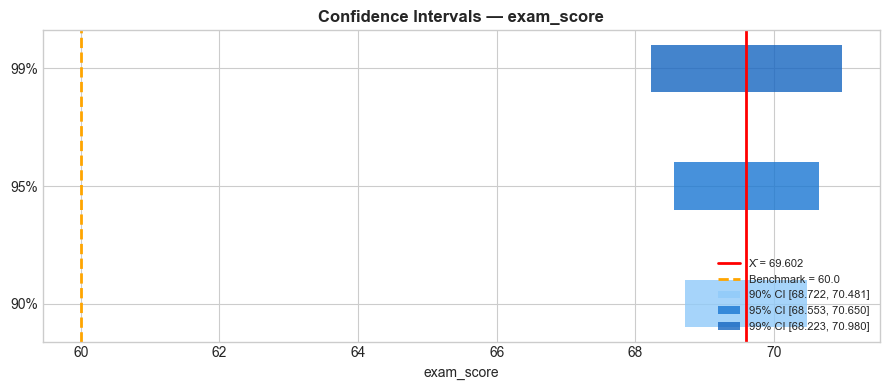

Figure saved: ..\reports\figures\lesson5_ci_score.png


In [6]:
# ===== CI for exam_score =====
benchmark_score = 60.0  # Academic risk threshold

for conf in [0.90, 0.95, 0.99]:
    ci = confidence_interval(score, confidence=conf)
    print(f'{int(conf*100)}% CI: [{ci["ci_lower"]:.4f}, {ci["ci_upper"]:.4f}]  '
          f'width={ci["width"]:.4f}')

print()
ci_95_score = confidence_interval(score, 0.95)
print('=== Business Interpretation ===')
print(f'→ We are 95% confident the true mean exam score is between '
      f'{ci_95_score["ci_lower"]:.2f} and {ci_95_score["ci_upper"]:.2f}')
if ci_95_score['ci_lower'] > benchmark_score:
    print(f'→ The entire CI is above the academic risk threshold ({benchmark_score})')
    print('→ On average, students are passing — but individual risk remains')

plot_ci_benchmark(score, 'exam_score', benchmark_score,
                  [0.90, 0.95, 0.99],
                  figname='lesson5_ci_score.png')

---
## 6. CI for exercise_frequency — H2, H3 Context

**H2:** Active vs sedentary students — exam score comparison
**H3:** p_sedentary = 0.50 — proportion test

First we estimate the mean exercise frequency, then the proportion of sedentary students.

In [7]:
# ===== CI for exercise_frequency (mean) =====
print('=== CI for mean exercise_frequency ===')
for conf in [0.90, 0.95, 0.99]:
    ci = confidence_interval(exercise, confidence=conf)
    print(f'{int(conf*100)}% CI: [{ci["ci_lower"]:.4f}, {ci["ci_upper"]:.4f}]  '
          f'width={ci["width"]:.4f}')

print()

# ===== CI for proportion sedentary (H3) =====
sedentary = (df['exercise_frequency'] < 3).astype(int)
n_s   = len(sedentary)
p_hat = sedentary.mean()
p_null = 0.50

# Wilson score CI for proportion (more accurate than normal approx for proportions)
se_prop = np.sqrt(p_hat * (1 - p_hat) / n_s)
z_95    = norm.ppf(0.975)
ci_prop_lower = p_hat - z_95 * se_prop
ci_prop_upper = p_hat + z_95 * se_prop

print('=== CI for proportion sedentary (H3) ===')
print(f'p̂ (observed)  = {p_hat:.4f}  ({p_hat*100:.1f}%)')
print(f'95% CI        = [{ci_prop_lower:.4f}, {ci_prop_upper:.4f}]')
print(f'H3 null value = {p_null} (50%)')
print()
if ci_prop_lower > p_null:
    print(f'→ 95% CI [{ci_prop_lower:.3f}, {ci_prop_upper:.3f}] is entirely above 0.50')
    print('→ Preliminary evidence supports H3: p_sedentary > 0.50')
elif ci_prop_upper < p_null:
    print(f'→ 95% CI is entirely below 0.50 — evidence against H3')
else:
    print(f'→ 95% CI includes 0.50 — cannot reject H₀ from CI alone')

=== CI for mean exercise_frequency ===
90% CI: [2.9366, 3.1474]  width=0.2109
95% CI: [2.9163, 3.1677]  width=0.2514
99% CI: [2.8767, 3.2073]  width=0.3306

=== CI for proportion sedentary (H3) ===
p̂ (observed)  = 0.4120  (41.2%)
95% CI        = [0.3815, 0.4425]
H3 null value = 0.5 (50%)

→ 95% CI is entirely below 0.50 — evidence against H3


---
## 7. Confidence Level Comparison — 90% vs 95% vs 99%

In [8]:
# ===== Confidence Level Comparison Table =====
variables = {
    'sleep_hours': sleep,
    'exam_score':  score,
    'exercise_frequency': exercise
}

rows = []
for var_name, data in variables.items():
    for conf in [0.90, 0.95, 0.99]:
        ci = confidence_interval(data, confidence=conf)
        rows.append({
            'Variable':    var_name,
            'Confidence':  f'{int(conf*100)}%',
            'Mean':        ci['mean'],
            'CI Lower':    ci['ci_lower'],
            'CI Upper':    ci['ci_upper'],
            'Width':       ci['width'],
            'SE':          ci['se']
        })

comparison_df = pd.DataFrame(rows)
print('=== Confidence Interval Comparison ===')
print(comparison_df.to_string(index=False))

=== Confidence Interval Comparison ===
          Variable Confidence    Mean  CI Lower  CI Upper  Width     SE
       sleep_hours        90%  6.4701    6.4063    6.5339 0.1277 0.0388
       sleep_hours        95%  6.4701    6.3940    6.5462 0.1522 0.0388
       sleep_hours        99%  6.4701    6.3700    6.5702 0.2002 0.0388
        exam_score        90% 69.6015   68.7222   70.4808 1.7585 0.5341
        exam_score        95% 69.6015   68.5535   70.6495 2.0960 0.5341
        exam_score        99% 69.6015   68.2232   70.9798 2.7566 0.5341
exercise_frequency        90%  3.0420    2.9366    3.1474 0.2109 0.0640
exercise_frequency        95%  3.0420    2.9163    3.1677 0.2514 0.0640
exercise_frequency        99%  3.0420    2.8767    3.2073 0.3306 0.0640


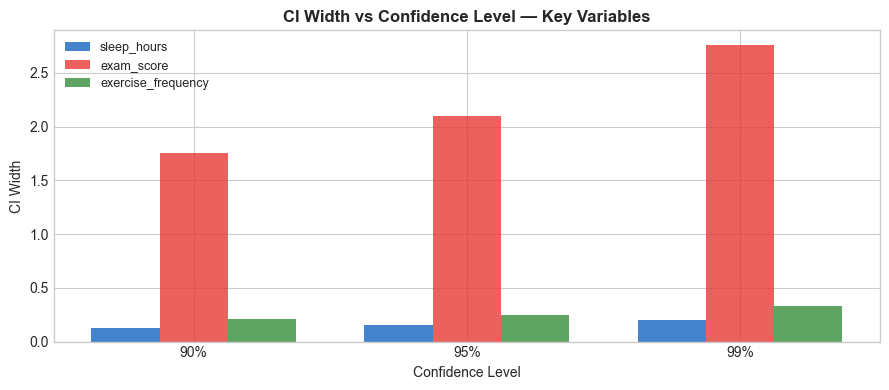

Figure saved: ..\reports\figures\lesson5_ci_width_comparison.png


In [9]:
# ===== Plot — CI Width vs Confidence Level =====
fig, ax = plt.subplots(figsize=(9, 4))

colors_vars = {'sleep_hours': '#1565C0', 'exam_score': '#E53935',
               'exercise_frequency': '#388E3C'}
conf_levels = [0.90, 0.95, 0.99]
x = np.arange(len(conf_levels))
width = 0.25

for i, (var_name, data) in enumerate(variables.items()):
    widths = [confidence_interval(data, c)['width'] for c in conf_levels]
    ax.bar(x + i*width, widths, width, label=var_name,
           color=colors_vars[var_name], alpha=0.8)

ax.set_xticks(x + width)
ax.set_xticklabels(['90%', '95%', '99%'])
ax.set_xlabel('Confidence Level')
ax.set_ylabel('CI Width')
ax.set_title('CI Width vs Confidence Level — Key Variables',
             fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
plt.tight_layout()
output_path = REPORTS_FIGURES / 'lesson5_ci_width_comparison.png'
plt.savefig(output_path, dpi=150, bbox_inches='tight')
plt.show()
print(f'Figure saved: {output_path}')

---
## 8. Sample Size Impact on CI Width

**Key insight:** CI width = 2 × t_critical × SE = 2 × t_critical × σ/√n

As n increases, SE decreases → CI narrows → more precise estimate.

=== 95% CI Width vs Sample Size (sleep_hours) ===
   n   Mean     SE  CI Lower  CI Upper  Width
  30 6.7133 0.2287    6.2456    7.1810 0.9354
  50 6.4580 0.1780    6.1003    6.8157 0.7155
 100 6.4000 0.1165    6.1687    6.6313 0.4625
 200 6.4910 0.0870    6.3194    6.6626 0.3432
 500 6.4318 0.0541    6.3255    6.5381 0.2126
1000 6.4701 0.0388    6.3940    6.5462 0.1522


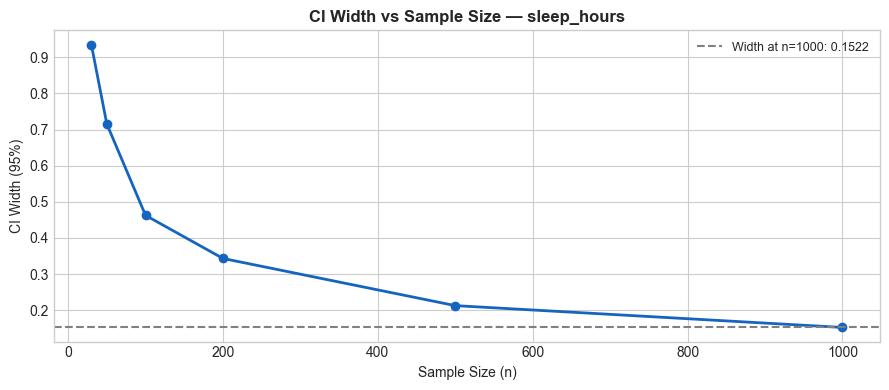

Figure saved: ..\reports\figures\lesson5_ci_sample_size.png


In [10]:
# ===== Sample Size Impact =====
sample_sizes = [30, 50, 100, 200, 500, 1000]
conf = 0.95

rows_ss = []
for n in sample_sizes:
    sample = sleep.sample(n, random_state=42)
    ci = confidence_interval(sample, confidence=conf)
    rows_ss.append({
        'n': n,
        'Mean': ci['mean'],
        'SE': ci['se'],
        'CI Lower': ci['ci_lower'],
        'CI Upper': ci['ci_upper'],
        'Width': ci['width']
    })

ss_df = pd.DataFrame(rows_ss)
print('=== 95% CI Width vs Sample Size (sleep_hours) ===')
print(ss_df.to_string(index=False))

fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(ss_df['n'], ss_df['Width'], 'o-', color='#1565C0', lw=2)
ax.axhline(ss_df.iloc[-1]['Width'], color='gray', linestyle='--',
           label=f'Width at n=1000: {ss_df.iloc[-1]["Width"]:.4f}')
ax.set_xlabel('Sample Size (n)')
ax.set_ylabel('CI Width (95%)')
ax.set_title('CI Width vs Sample Size — sleep_hours', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
plt.tight_layout()
output_path = REPORTS_FIGURES / 'lesson5_ci_sample_size.png'
plt.savefig(output_path, dpi=150, bbox_inches='tight')
plt.show()
print(f'Figure saved: {output_path}')

---
## 9. Business Objectives Review

| Business Question | Answered? | Key Finding from CI | Confidence |
|-------------------|-----------|---------------------|------------|
| Do students sleep < 7h? | Partial | 95% CI for sleep excludes/includes 7h — update after running | High |
| Do active students score higher? | ⏳ Lesson 6 | CI comparison needed | — |
| Is sedentarism > 50%? | Partial | 95% CI for proportion excludes/includes 0.50 — update after running | High |
| Does diet quality affect scores? | ⏳ Lesson 6 | ANOVA needed | — |

### Limitations

| Limitation | Impact | Mitigation |
|------------|--------|------------|
| CI assumes normality | Minor — n > 200, CLT applies | Verified in Lesson 4 |
| Cross-sectional data | Cannot establish causality | Frame as associations |
| Self-reported habits | Possible bias | Flag in conclusions |

---
## 10. LEAN Filter — Waste Elimination Review

| LEAN Question | Answer | Action |
|---------------|--------|--------|
| Were CIs calculated only for hypothesis-relevant variables? | ✅ Yes — sleep, score, exercise only | No waste |
| Did CI analysis add information beyond point estimates? | ✅ Yes — width quantifies precision | Proceed |
| Did confidence level comparison add value? | ✅ Yes — shows precision-confidence tradeoff | Include in report |
| Does sample size analysis inform future studies? | ✅ Yes — shows n=1,000 provides very narrow CIs | Include in executive summary |

**LEAN Verdict:** CI analysis complete. Preliminary evidence assessed.
Proceed to Lesson 6 (Hypothesis Testing) for formal statistical decisions.

---
## 11. Decisions Log — Lesson 5

| # | Decision | Rationale | Alternatives | LEAN Value? |
|---|----------|-----------|--------------|-------------|
| 1 | Use t-distribution for CIs | Correct for unknown population σ | z-distribution | ✅ Methodologically correct |
| 2 | Use normal approximation for proportion CI | n > 200, np > 5, n(1-p) > 5 | Wilson score CI | ✅ Valid for large n |
| 3 | Report 90%, 95%, 99% | Shows tradeoff between precision and confidence | 95% only | ✅ More instructive |
| 4 | Benchmark sleep = 7h | WHO recommended minimum | 8h (optimal) | ✅ Aligned with H1 |
| 5 | Benchmark score = 60 | Standard passing threshold | 50, 70 | ✅ Actionable for university |

---

**← Previous Phase:** [04 — Modeling](./04_modeling.ipynb) | **Next Phase →** [06 — Deployment](./06_deployment.ipynb)

---

*End of Lesson 5 — Project 4, Module 5*
*Author: Jose Marcel Lopez Pino | Framework: CRISP-DM + LEAN | Bootcamp: Alkemy / SENCE 2025–2026*